In [11]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Datasets de Bolsa de Valores


In [12]:
#Guarda los valores de una accion en particular(ticke), de un periodo de tiempo en un dataframe
#este caso es el Standard & Poor's 500 - S&P500
sp500_10y = yf.Ticker("^GSPC").history(period="10y")

#Mestra la cabecera del dataframe
sp500_10y.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-11 00:00:00-04:00,1992.849976,1997.650024,1985.930054,1997.449951,2941690000,0.0,0.0
2014-09-12 00:00:00-04:00,1996.739990,1996.739990,1980.260010,1985.540039,3206570000,0.0,0.0
2014-09-15 00:00:00-04:00,1986.040039,1987.180054,1978.479980,1984.130005,2776530000,0.0,0.0
2014-09-16 00:00:00-04:00,1981.930054,2002.280029,1979.060059,1998.979980,3160310000,0.0,0.0
2014-09-17 00:00:00-04:00,1999.300049,2010.739990,1993.290039,2001.569946,3209420000,0.0,0.0


# Red LSTM 

In [13]:
np.random.seed(4)

set_entrenamiento = sp500_10y[:'2022'].iloc[:,1:2]
set_validacion = sp500_10y['2023':].iloc[:,1:2]

sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))




dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50

modelo = Sequential()

modelo.add(LSTM(units=na, input_shape=dim_entrada))

modelo.add(Dense(units=dim_salida))

modelo.compile(optimizer='rmsprop', loss='mse')

modelo.fit(X_train,Y_train,epochs=20,batch_size=32)


x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

c:\Users\jrgui\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0185
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0010
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0011
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 8.1372e-04
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 6.6431e-04
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 5.3311e-04
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 6.2170e-04
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 5.9838e-04
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 4.7493e-04
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 4.1761e-04
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.1355e-04
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.0964e-04
Epoch 13/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.3211e-04
Epoch 14/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3.2356e-04
Epoch 15/20
64/64 ━━━━━━━━━

c:\Users\jrgui\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


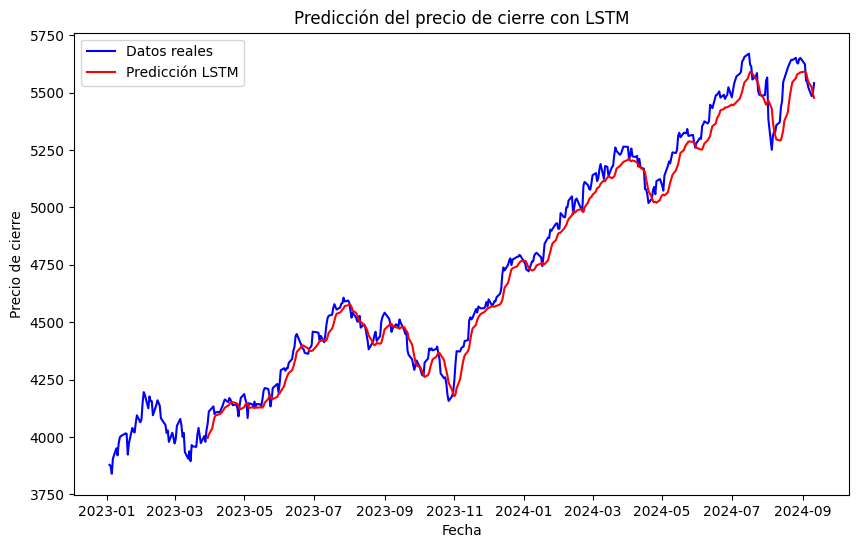

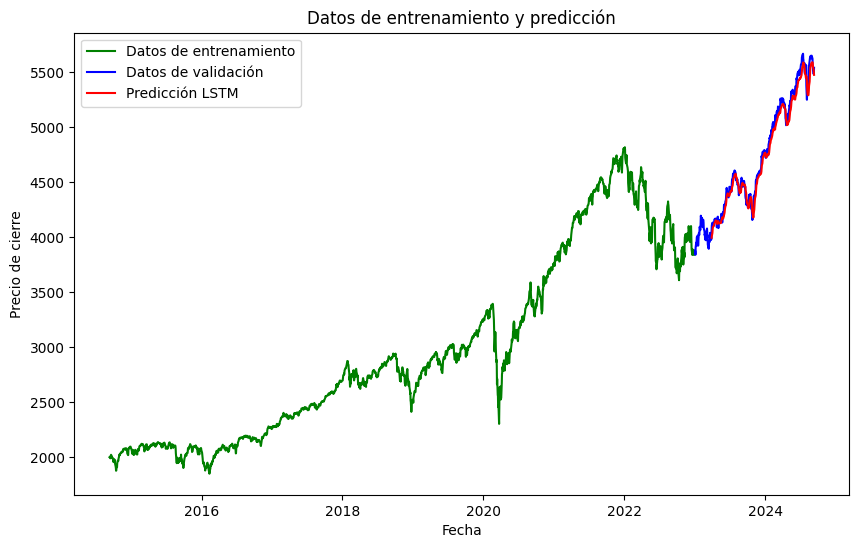

In [14]:
# Preparar datos originales de validación para graficar
set_validacion['Prediccion'] = np.nan
set_validacion['Prediccion'].iloc[time_step:] = prediccion.flatten()

# Gráfico 1: Datos reales de validación vs predicción
plt.figure(figsize=(10,6))
plt.plot(set_validacion.index, set_validacion.iloc[:,0], color='blue', label='Datos reales')
plt.plot(set_validacion.index, set_validacion['Prediccion'], color='red', label='Predicción LSTM')
plt.title('Predicción del precio de cierre con LSTM')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.legend()
plt.show()

# Gráfico 2: Datos de entrenamiento y validación con predicción
# Preparar una serie combinada para graficar
train_size = len(set_entrenamiento)
valid_size = len(set_validacion)
dataset_total = pd.concat([set_entrenamiento, set_validacion], axis=0)

plt.figure(figsize=(10,6))
plt.plot(dataset_total.index[:train_size], dataset_total.iloc[:train_size,0], color='green', label='Datos de entrenamiento')
plt.plot(dataset_total.index[train_size:], dataset_total.iloc[train_size:,0], color='blue', label='Datos de validación')
plt.plot(dataset_total.index[train_size+time_step:], set_validacion['Prediccion'].dropna(), color='red', label='Predicción LSTM')
plt.title('Datos de entrenamiento y predicción')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.legend()
plt.show()
